In [35]:
import torch

In [36]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


In [37]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Definir transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descargar conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dividir el conjunto de entrenamiento en 80% entrenamiento y 20% validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir la arquitectura de la SNN
class SNN(nn.Module):
    def __init__(self, hidden_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar las imágenes
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Función para entrenar y validar el modelo
def train_and_validate_snn(hidden_size):
    model = SNN(hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenamiento
    model.train()
    for epoch in range(5):  # Entrenar por 5 épocas
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_error = 1 - correct / total  # Calcular el error de validación
    total_params = sum(p.numel() for p in model.parameters())  # Número de parámetros

    return val_error, total_params

In [39]:
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28
        for hidden_size in hidden_layers:
            self.layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.layers.append(nn.Linear(input_size, 10))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# Función para entrenar y validar la MLP
def train_and_validate_mlp(hidden_layers):
    model = MLP(hidden_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenamiento
    model.train()
    for epoch in range(5):  # Entrenar por 5 épocas
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_error = 1 - correct / total
    total_params = sum(p.numel() for p in model.parameters())

    return val_error, total_params

Training MLP (layers: [128, 256]): 100%|██████████| 3750/3750 [00:29<00:00, 127.69it/s]


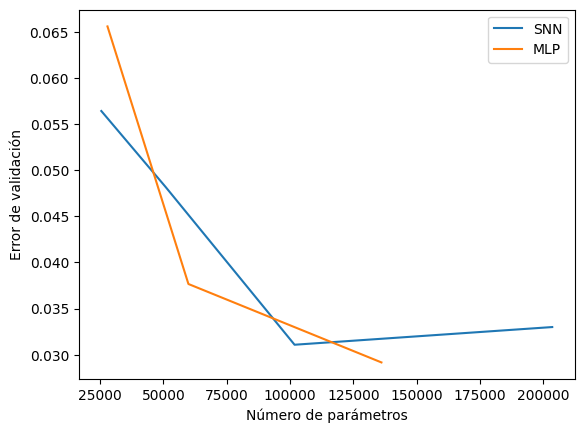

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Para mostrar la barra de progreso

# Definir la arquitectura de la SNN
class SNN(nn.Module):
    def __init__(self, hidden_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Aplanar las imágenes
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Función para entrenar y validar el modelo SNN con barra de progreso
def train_and_validate_snn(hidden_size):
    model = SNN(hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5  # Número de épocas
    total_batches = len(train_loader) * epochs  # Número total de lotes en todas las épocas
    progress_bar = tqdm(total=total_batches, desc=f'Training SNN (hidden size: {hidden_size})')

    # Entrenamiento
    model.train()
    for epoch in range(epochs):  # Entrenar por 5 épocas
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            progress_bar.update(1)  # Actualizar la barra de progreso

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_error = 1 - correct / total  # Calcular el error de validación
    total_params = sum(p.numel() for p in model.parameters())  # Número de parámetros

    progress_bar.close()
    return val_error, total_params


# Definir la arquitectura de la MLP
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28
        for hidden_size in hidden_layers:
            self.layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.layers.append(nn.Linear(input_size, 10))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# Función para entrenar y validar la MLP con barra de progreso
def train_and_validate_mlp(hidden_layers):
    model = MLP(hidden_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5  # Número de épocas
    total_batches = len(train_loader) * epochs
    progress_bar = tqdm(total=total_batches, desc=f'Training MLP (layers: {hidden_layers})')

    # Entrenamiento
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            progress_bar.update(1)  # Actualizar la barra de progreso

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_error = 1 - correct / total
    total_params = sum(p.numel() for p in model.parameters())

    progress_bar.close()
    return val_error, total_params


import matplotlib.pyplot as plt

# Listas para guardar resultados
snn_errors, snn_params = [], []
mlp_errors, mlp_params = [], []

# Experimentar con diferentes tamaños de capa para SNN
for hidden_size in [32, 64, 128, 256]:
    val_error, total_params = train_and_validate_snn(hidden_size)
    snn_errors.append(val_error)
    snn_params.append(total_params)

# Experimentar con diferentes arquitecturas MLP
for hidden_layers in [[32, 64], [64, 128], [128, 256]]:
    val_error, total_params = train_and_validate_mlp(hidden_layers)
    mlp_errors.append(val_error)
    mlp_params.append(total_params)

# Graficar los resultados
plt.plot(snn_params, snn_errors, label='SNN')
plt.plot(mlp_params, mlp_errors, label='MLP')
plt.xlabel('Número de parámetros')
plt.ylabel('Error de validación')
plt.legend()
plt.show()


In [41]:
import matplotlib.pyplot as plt

# Listas para guardar los errores finales (después de todas las épocas) y el número de parámetros
snn_train_final_errors, snn_val_final_errors, snn_params = [], [], []
mlp_train_final_errors, mlp_val_final_errors, mlp_params = [], [], []

# Experimentar con diferentes tamaños de capa para SNN
for hidden_size in [32, 64, 128, 256]:
    train_errors, val_errors, total_params = train_and_validate_snn(hidden_size)
    
    # Guardar el error final (última época)
    snn_train_final_errors.append(train_errors[-1])
    snn_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    snn_params.append(total_params)

# Experimentar con diferentes arquitecturas MLP
for hidden_layers in [[32, 64], [64, 128], [128, 256]]:
    train_errors, val_errors, total_params = train_and_validate_mlp(hidden_layers)
    
    # Guardar el error final (última época)
    mlp_train_final_errors.append(train_errors[-1])
    mlp_val_final_errors.append(val_errors[-1])
    
    # Guardar el número total de parámetros
    mlp_params.append(total_params)

Training SNN (hidden size: 32): 100%|██████████| 3750/3750 [00:25<00:00, 146.68it/s]


ValueError: not enough values to unpack (expected 3, got 2)

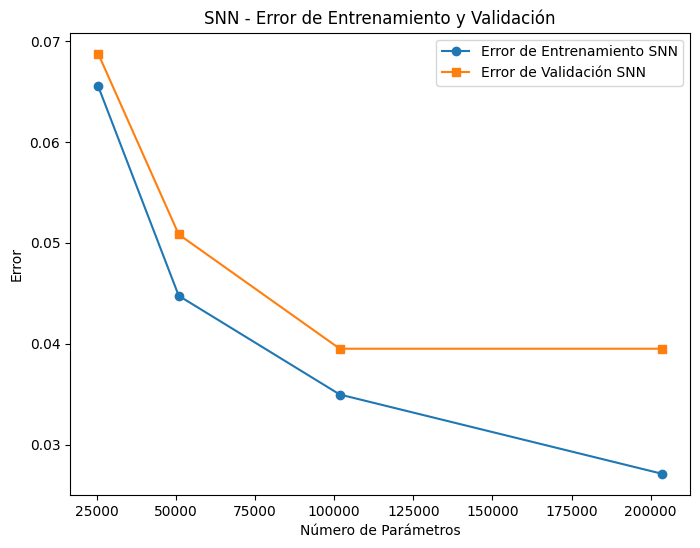

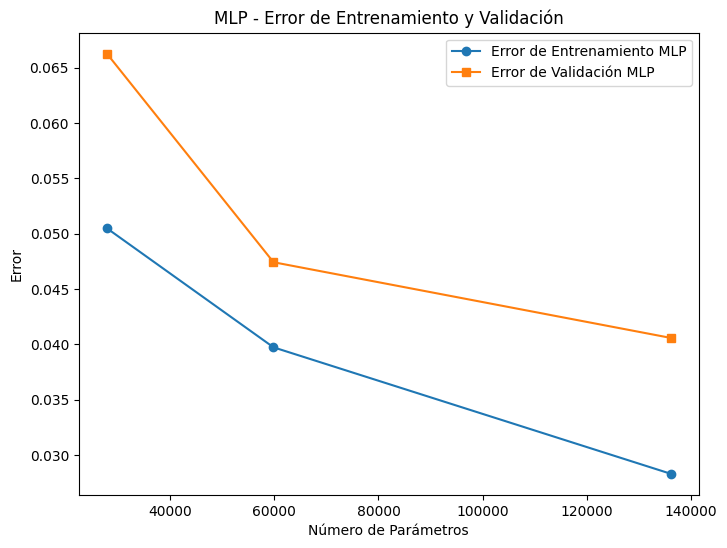

In [27]:
# Graficar los resultados

# Gráfica de SNN
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(snn_params, snn_train_final_errors, 'o-', label='Error de Entrenamiento SNN')
plt.plot(snn_params, snn_val_final_errors, 's-', label='Error de Validación SNN')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('SNN - Error de Entrenamiento y Validación')
plt.legend()
plt.show()

# Gráfica de MLP
plt.figure(figsize=(8, 6))
# Graficar tanto el error de entrenamiento como el error de validación en una sola gráfica para MLP
plt.plot(mlp_params, mlp_train_final_errors, 'o-', label='Error de Entrenamiento MLP')
plt.plot(mlp_params, mlp_val_final_errors, 's-', label='Error de Validación MLP')
# Añadir etiquetas y título
plt.xlabel('Número de Parámetros')
plt.ylabel('Error')
plt.title('MLP - Error de Entrenamiento y Validación')
plt.legend()
plt.show()